In [25]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [26]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

In [27]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [28]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [29]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [30]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [31]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [32]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [33]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Precipitation Analysis

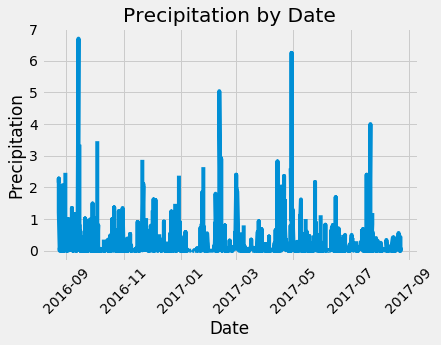

In [34]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date 1 year ago from the last data point in the database
y, m, d = [int(item) for item in query[0].split("-")]
cutoff = dt.datetime(y-1, m, d)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
twelve_months = session.query(*sel).filter(func.strftime(sel[0]) >= cutoff).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
weather_df = pd.DataFrame(twelve_months, columns = ['date', 'prcp'])
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df.set_index('date', inplace = True)

# Sort the dataframe by date
weather_df.sort_values(by=['date'], inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(weather_df['prcp'])
plt.title('Precipitation by Date')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.show()

In [35]:
# Use Pandas to calculate the summary statistics for the precipitation data
weather_df['prcp'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

### Station Analysis

In [36]:
# Design a query to show how many stations are available in this dataset?
count = session.query(Station.name).count()
print(f'Station count: {count}')

Station count: 9


In [37]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [
    Measurement.station,
    func.count(Measurement.station)
]

query = session.query(*sel).group_by(sel[0]).order_by(sel[1].desc()).all()

# Put query on a dataframe, looks nicer!
df_most_active = pd.DataFrame(query, columns = ['station_id', 'count'])
df_most_active.set_index('station_id', inplace = True)
df_most_active

,count
station_id,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [38]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = session.query(sel[0]).group_by(sel[0]).order_by(sel[1].desc()).first()[0]

sel = [
    Measurement.station,
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
]
query = session.query(*sel).filter(sel[0] == most_active).all()[0]

# Print out results
station, lowest, highest, avg = query
print(f'Station ID: {station}')
print(f'Lowest temp: {lowest}')
print(f'Highest temp: {highest}')
print(f'Avg temp: {avg}')

Station ID: USC00519281
Lowest temp: 54.0
Highest temp: 85.0
Avg temp: 71.66378066378067


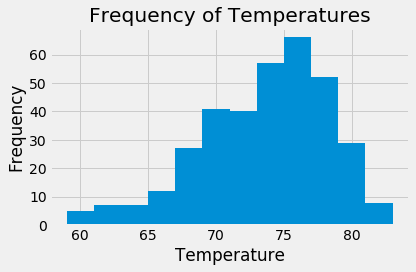

In [39]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

query = session.query(Measurement.tobs).filter(Measurement.station == most_active).\
    filter(func.strftime(Measurement.date) > cutoff).all()

# Add query results to dataframe
df_tobs = pd.DataFrame(query, columns = ['tobs'])

# Create histogram
plt.hist(df_tobs['tobs'], bins = 12)
plt.title('Frequency of Temperatures')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Optional Challenge Assignment

### Temperature Analysis I

In [40]:
# Queries to obtain temperatures
jun_query = session.query(Measurement.tobs).\
    filter(func.strftime("%m", Measurement.date) == "06").all()

dec_query = session.query(Measurement.tobs).\
    filter(func.strftime("%m", Measurement.date) == "12").all()

# Convert to dataframe for data manipulation
jun_df = pd.DataFrame(jun_query)
dec_df = pd.DataFrame(dec_query)

ttest_ind(jun_df['tobs'], dec_df['tobs'])

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

There is a statistically significant difference between the means in both samples which is indicated with a p-value of less 0.05. A paired t-test was performed as both samples are independt of each other.

### Temperature Analysis II

In [41]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [42]:
# Run query and create dataframe
query = calc_temps('2017-01-01', '2018-01-01')
data = []
data = list(np.ravel(query))
data

[58.0, 74.14387974230493, 87.0]

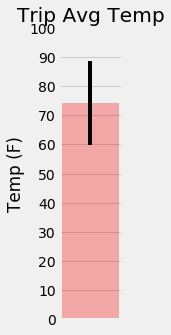

In [43]:
# Create plot
plt.figure(figsize=(1, 5))
plt.bar(x = 0, height = data[1], alpha = 0.3, width = 1, color = 'red', yerr = (data[2] - data[0])/2)
plt.xticks([])
plt.yticks(np.arange(0, 110, 10))
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.grid(10)

plt.show()

### Daily Rainfall Average

In [60]:
# Rainfall per weather station
sel = [
    Measurement.station,
    func.sum(Measurement.prcp)
]

query = session.query(*sel).filter(func.strftime(sel[0]) >= cutoff).group_by(sel[0]).all()
avg_prcp = pd.DataFrame(query, columns = ['station', 'sum_prcp'])
avg_prcp

,station,sum_prcp
0,USC00511918,92.68
1,USC00513117,382.62
2,USC00514830,234.49
3,USC00516128,1068.09
4,USC00517948,43.44
5,USC00518838,70.87
6,USC00519281,588.64
7,USC00519397,131.62
8,USC00519523,295.68


In [83]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# Test
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [87]:
# Pick dates for trip, using birthday week
trip_dates = [
    '03-06-2020',
    '03-07-2020',
    '03-08-2020',
    '03-09-2020',
    '03-10-2020',
    '03-11-2020',
    '03-12-2020'
]

# Create dataframe from daily_normals func
data = {}

for date in trip_dates:
    data[date] = list(np.ravel(daily_normals(date[0:5])))

trip_df = pd.DataFrame.from_dict(data, orient = 'index', columns = ['tmin', 'tavg', 'tmax'])
trip_df

,tmin,tavg,tmax
03-06-2020,60.0,69.203390,76.0
03-07-2020,60.0,69.172414,78.0
03-08-2020,59.0,68.724138,78.0
03-09-2020,57.0,68.561404,75.0
03-10-2020,57.0,69.122807,75.0
03-11-2020,60.0,69.892857,82.0
03-12-2020,62.0,69.888889,80.0


Text(0.5, 1.0, 'Daily Normals')

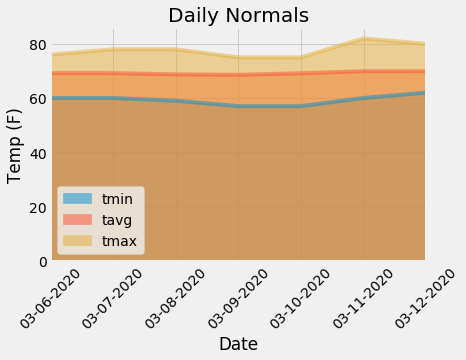

In [121]:
# Plot dataframe
ax = trip_df.plot.area(stacked = False, rot = 45)
ax.set_xlabel('Date')
ax.set_ylabel('Temp (F)')
ax.set_title('Daily Normals')